<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/Alex_HershU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-31lldpg3
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-31lldpg3
  Resolved https://github.com/pydata/xarray.git to commit c25215299c02cd36781cf3aa38e8583d1fe14849
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev1+gc2521529-py3-none-any.whl size=1247984 sha256=86fa1b086bcb3f91dd99d4e7ed09d4af212202667ff7fdd2309bfff7ed3c9250
  Stored in directory: /tmp/pip-ephem-wheel-cache-mc_94jai/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1


In [2]:
import xarray as xr

In [3]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.1 MB/s eta 0:00:00


In [4]:
import bambi as bmb

In [5]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

# How Often do Players foul in basketball

## Introdcution

I'm going to be looking at how often players commit personal fouls (pfs per min) in basketball. A personal foul in basketball is when a player gets too physical with another player. For example, shoving somebody is a personal foul.

I'm interested in seeing how diffeent variables mix together in conjunction with personal fouls. I'll be using the basketball 23-24 dataset, but I'll only look at players with at least 400 minutes played to avoid strong outliers. Also, I'm going to ignore the nonstandard positions because very few people don't play one of the standard five positions.

## Assumptions

I'm assuming very little. I know little about how all these variables work together, except that centers foul more. I'll be using bambi's default priors to reflect this uncertainty. This goes with my assumtion that I know very little since bambi uses weak priors.

I'm also going to assume that the relationships on my DAG are correct. I'll be using my DAG to dictate my variable selection, so I'm assuming that my DAG shows patterns that actually exist in reality. There are too many relationships to list them all here, but I'll include the most important ones.


When I was going about this project, I was thinking about two categories of things that cause a players fouls perm minute. One, events that have a chance to cause fouls, and two, how a player handles these events. For example, attempting a block may lead to a personal foul. Therefore, block attempts cause personal fouls. I also have the number of succesful blocks, BLK, being caused by the number of attempted blocks. BLK is useful because it's my best indicator for the number of attempted blocks. STL attempts, STL, TOV attempts, TOV, DRB attempts, and DRB are on the DAG for the same reason as block attempts and BLK.

A player's position also impacts how often they have an opportunity to foul. Different positions have different roles and different roles entail different opportunities for personal fouls.

Lastly, for events which cause personal fouls, I have MP (minutes played). A player who plays more is a better player and my assumption, which may very well be wrong, is that better players are typically better at avoiding events where they would foul another player. (Note that PFs per minute could also cause personal fouls because fouling too much gets you kicked out of the game. Because we haven't learned otherwise I'm assuming this is only a one way causal relationship, but it's important to remember that that is a slightly faulty assumption).


Physicality, how physical a player's playstyle is, is on my DAG because I consider it to be the factor which determines how often a player fouls when they are put in a position where they could foul. A more physical player would foul more often when going for a block, for example.

There is no variable which measures physicality so I'll have to use other variables in it's place. The things which cause physicality according to my DAG are a player's height, weight, age, and position. On the other hand, I think physicality cause almost everything else in football. Players who are more physical typically shoot worse from long range because their playstyle (or physicality) isn't suited for long range shots. More physical players may also go for more blocks, steals, and rebounds.

While none of these variables directly impacts personal fouls per minute, I'm assuming their relathionship with physicality is clear enough that there is a clear relationship between these variables and personal fouls per minute.

Because of my uncertainty, I'm going to be testing quite a few models. I'm assuming the relationships on my DAG are correct, but I'm not assuming they are strong. I'll try quite a few combinations, all including Pos because it's just too important to ignore, to try and find a good one.

I'm also going to try to avoid using variables that are dependent on each other together. If two variables are dependent on each other, then using them both wouldn't be better than just using one. Instead, it will lead to overfitting and be bad.

## Data

As I said before, I'm using the basketball 23-24 dataset.

In [6]:
basketball = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv').dropna() # loading the dataset and removing any NAs

In [7]:
basketball = basketball.query('MP > 400') # removing players who've played 400 minutes or less in the season

In [8]:
basketball = basketball.query("Pos in ['C','PF','SF','SG','PG']") # only taking players from the main positions
basketball = basketball.reset_index(drop=True) # the indexes get messed up for some reason so I have to reset them

In [9]:
PF_per_min = basketball.PF / basketball.MP # creating the variable for personal fouls per minute
basketball.insert(loc = 2, column='PF_per_min', value = PF_per_min)

In [10]:
basketball = basketball.reset_index(drop=True) # just to be safe

Now, I'm going to make some graphs to get a better idea of the data. I won't include all the relationships; I'm going to cherrypick the ones that look significant to me.

(array([  7.,  45.,  79., 107.,  57.,  47.,  10.,   9.,   3.,   1.]),
 array([0.02483187, 0.04011781, 0.05540376, 0.0706897 , 0.08597564,
        0.10126159, 0.11654753, 0.13183348, 0.14711942, 0.16240537,
        0.17769131]),
 <BarContainer object of 10 artists>)

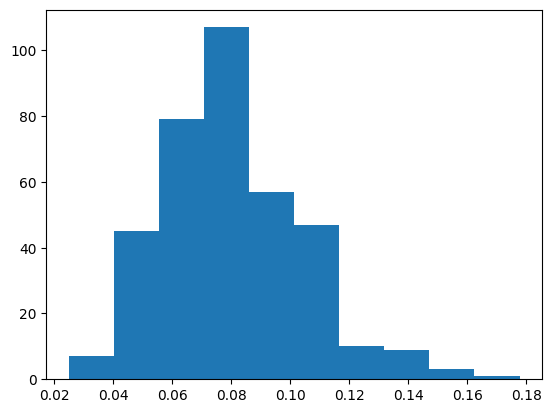

In [11]:
plt.hist(PF_per_min)

This is the personal fouls per minute of all basketball players who played more than 400 minutes. It has a decent skew to the right and looks like it may be gamma distributed.

In [12]:
color = [] # the entirety of this block of code is just a really ugly way to get the parts of the data I need to properly make the graphs.
posPF = [[],[],[],[],[],[]] # There is probably a better way to reorganize the data, but I don't know how.
pospos = ['C', 'PF', 'SF', 'PG', 'SG']
colors = ['red','yellow','green','blue','purple']
for i in range(len(basketball.Pos)):
  pos = basketball.Pos[i]
  if (pos == 'C'):
    posPF[0].append(basketball.PF_per_min[i])
    color.append(colors[0])
  elif (pos == 'PF'):
    posPF[1].append(basketball.PF_per_min[i])
    color.append(colors[1])
  elif (pos == 'SF'):
    posPF[2].append(basketball.PF_per_min[i])
    color.append(colors[2])
  elif (pos == 'PG'):
    posPF[3].append(basketball.PF_per_min[i])
    color.append(colors[3])
  elif (pos == 'SG'):
    posPF[4].append(basketball.PF_per_min[i])
    color.append(colors[4])
  else:
    posPF[5].append(basketball.PF_per_min[i])
    color.append(colors[5])

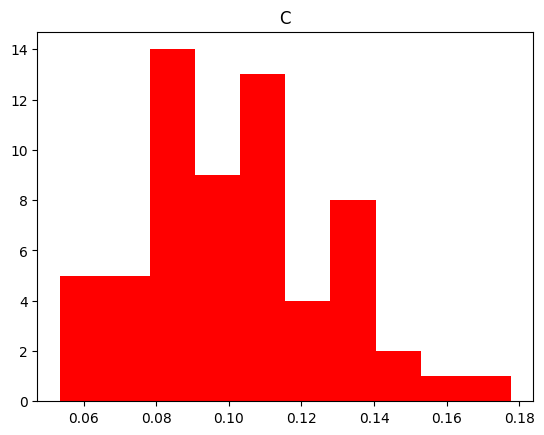

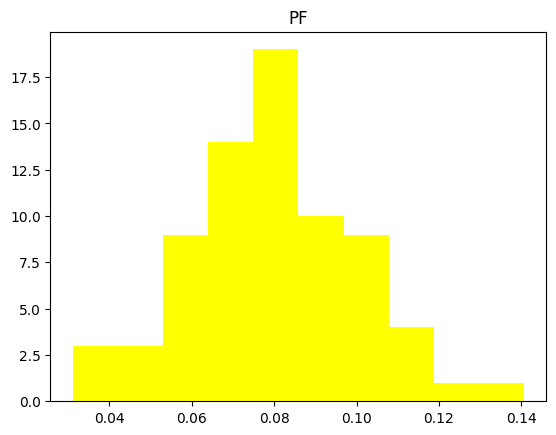

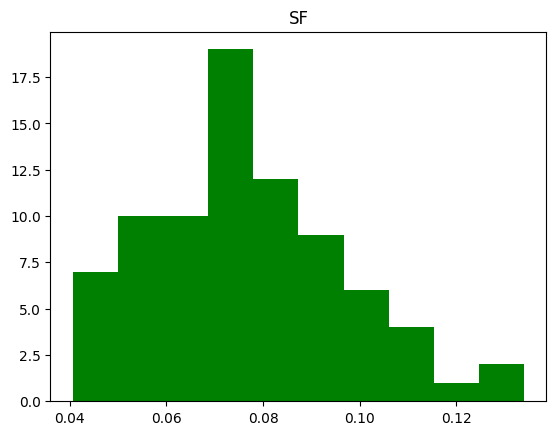

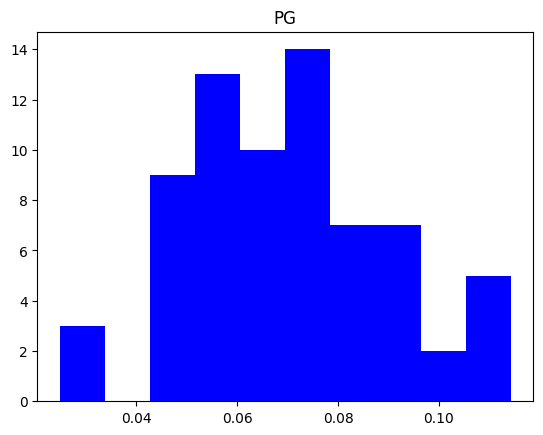

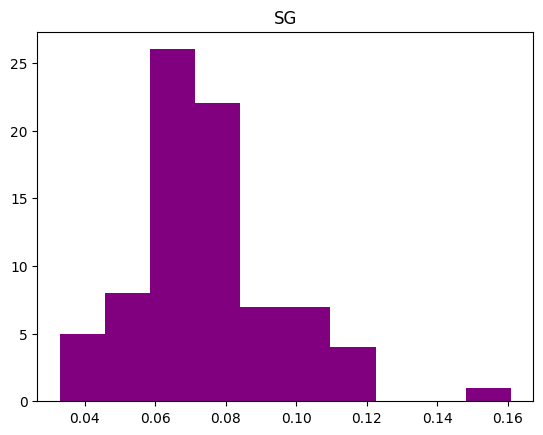

In [13]:
for i in range(5):
  fig, ax = plt.subplots()
  ax.hist(posPF[i], color=colors[i])
  ax.set_title(pospos[i])

These are the graphs for the personal fouls for each position. Note that the x axes aren't properly aligned.

The main significance of these graphs is that centers foul more while the other positions are about the same.

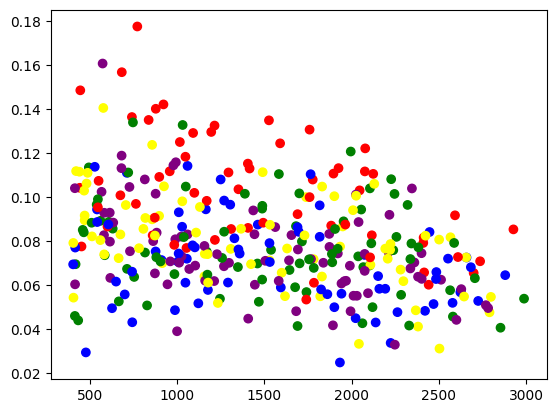

In [14]:
plt.scatter(basketball.MP,basketball.PF_per_min, color=color)

The x-axis for the above graph is minutes playerd and the y axis is fouls per minute. The colors represent position.

Red = centers, yellow = power forwards, green = short forwards, blue = point guards, and purple = shooting guards.

There seems to be a decently significant trend, but the trend does seem to depend on position. Also, the trend is what I predicted. Players who play more foul less often.

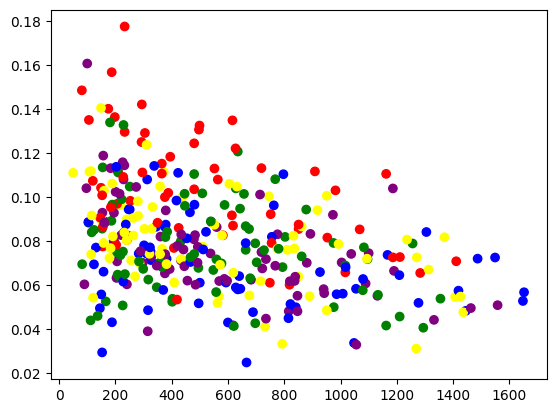

In [15]:
plt.scatter(basketball.FGA,basketball.PF_per_min,color=color)

The above graph is field goal attempts and fouls per minute. This seems similar to the pervious graph but with a clearer downward trend for each position. It's unclear whether the slopes are the same based on this graph. The red dots seem to have a different slope, but that could just be my eyes.

## Likelihood

My likelihood, following the overall trend I saw in the data, must be skew right. I also know my data is approximately modeling how often an event (a personal foul) occurs in a players total play time (MP). How many times an event happens in a certain time is modelled by a poisson distribution. My data is continuous so I'll be using the gamma distribution, basically the continuous version of the poisson distribution.

I'll also use a normal distribution to show the gamma distribution is actually better.

I'll be using a log link because I think personal fouls per minute shouldn't go too high but I do think they have some variability in low ranges. Also because bambi's poor gamma function breaks with any other link function.

# Models

In [16]:
modelDict = {} # the dictionary I'll give to arviz to compare models

I'm going to first run a test to make sure my link and likelihood function are good choices. I'll be modelling personal fouls per minute by position and steals, positions becaue its just really significant and steals so there is a quantitative variable.

In [18]:
model_bb1 = bmb.Model("PF_per_min ~ Pos + STL", data=basketball, link='log', family='gamma') # gamma likelihood with log link
idata_bb1 = model_bb1.fit(idata_kwargs={'log_likelihood': True})
modelDict['Gamma-log: Pos + STL'] = idata_bb1

Output()

Output()

In [ ]:
model_bb2 = bmb.Model("PF_per_min ~ Pos + STL", data=basketball, link='log') # normal likelihood with log link
idata_bb2 = model_bb2.fit(idata_kwargs={'log_likelihood': True})
modelDict['Normal-log: Pos + STL'] = idata_bb2

Output()

Output()

In [ ]:
cmp_df = az.compare( modelDict )
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gamma-log: Pos + STL,0,894.239284,6.88733,0.000000,0.752002,13.808155,0.000000,False,log
Normal-log: Pos + STL,1,885.165400,6.73793,9.073885,0.247998,14.287897,6.352256,False,log


As expected, the gamma likelihood worked better. It's not significant, but since it conforms to reality I'll be using a gamma likelihood from here on out.

Now that I know my choice of likelihood and link function were correct, I'm going to test a few models. All of my models are based on my DAG, and they'll vary in specificty. I'll always include position and a variable to model physicality since I think these are the two most significant things. I'll also try and include something like BLK or STL most of the time.

First, I'm going to look at simple non-interaction models.

In [ ]:
possibleVarsNoInt = ['Pos', 'Pos + BLK', 'Pos + STL', 'Pos + "FT%"', 'Pos + FGA', 'Pos + TRB', 'MP', 'Pos + "FT%" + STL', 'Pos + Age + STL'] # The first combinations I'm trying

In [ ]:
for var in possibleVarsNoInt: # This is just a function to try every predictor variabe in a list. I'm only doing this so my code take up too many lines
  print(var)
  model_basketball = bmb.Model("PF_per_min ~ " + var, data=basketball, family='gamma', link='log')
  idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})
  modelDict['Gamma-log: ' + var] = idata_basketball

Pos


Output()

Output()

Pos + BLK


Output()

Output()

Pos + STL


Output()

Output()

Pos + "FT%"


Output()

Output()

Pos + FGA


Output()

Output()

Pos + TRB


Output()

Output()

Pos + "FT%" + STL


Output()

Output()

Pos + Age + STL


Output()

Output()

In [ ]:
cmp_df = az.compare( modelDict )
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gamma-log: Pos + FGA,0,915.643389,6.801345,0.000000,7.450789e-01,14.472756,0.000000,False,log
Normal-log: Pos + MP,1,904.363540,6.826951,11.279850,2.246994e-01,14.472113,7.089657,False,log
"Gamma-log: Pos + ""FT%"" + STL",2,903.492396,7.953218,12.150994,5.275504e-14,14.222485,5.472318,False,log
Gamma-log: Pos + TRB,3,898.608457,6.935456,17.034933,0.000000e+00,14.179741,5.164182,False,log
Gamma-log: Pos + Age + STL,4,896.764305,8.100885,18.879084,0.000000e+00,13.656506,6.070533,False,log
"Gamma-log: Pos + ""FT%""",5,896.096652,6.993876,19.546738,3.022172e-02,14.321187,7.018383,False,log
Gamma-log: Pos + STL,6,894.317851,6.833367,21.325539,0.000000e+00,13.848483,5.242132,False,log
Gamma-log: Pos + BLK,7,888.677678,6.249288,26.965711,0.000000e+00,14.240934,6.608570,False,log
Normal-log: Pos + STL,8,885.165400,6.737930,30.477990,1.975850e-15,14.287897,8.649684,False,log
Gamma-log: Pos,9,885.106611,5.955181,30.536778,0.000000e+00,14.231527,7.393628,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

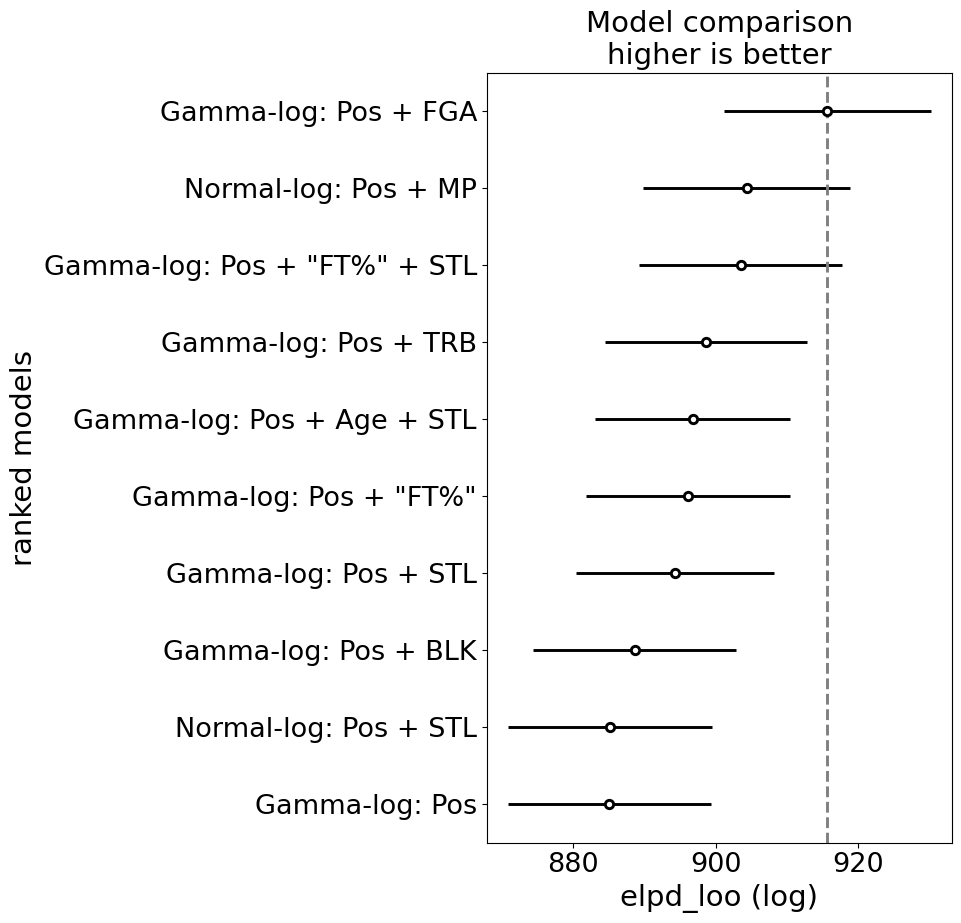

In [ ]:
az.plot_compare(cmp_df)

My major takeaways from this is that Pos + FGA is pretty good. Pos + MP and Pos + FT% + STL also perform well, but it seems Pos + FGA just does better. It's not significant though. (The normal-log: Pos + MP is a gamma, it's just a typo).

I'm now going to try some simple interaction models. I'll do a few with FGA since it seems pretty significant (it also looked significant when graphing it). FGA is likely performing well because it both is an indication of MP and physicality, both of which cause PFs.

My interaction will commonly be with MP. Before I've been using other variables as a combination of MP and how often something is done, but I'll be making it clearer by combining MP with certain variables.

In [ ]:
possibleVarsInt = ['Pos + FGA:MP', 'Pos + FGA:Pos', 'Pos + STL:MP', 'Pos + TRB:MP', 'Pos + STL:Pos + FGA', 'Pos + TOV:MP', 'Pos + "FT%":Pos'] # The second combinations I'm trying

In [ ]:
for var in possibleVarsInt: # This is just a function to try every predictor variabe in a list. I'm only doing this so my code take up too many lines
  print(var)
  model_basketball = bmb.Model("PF_per_min ~ " + var, data=basketball, family='gamma', link='log')
  idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})
  modelDict['Gamma-log: ' + var] = idata_basketball

Pos + FGA:MP


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(0.11751172), 'Intercept': array(0.45916529), 'Pos': array([-0.98392881, -0.8587306 ,  0.91447254,  0.59498178]), 'FGA:MP': array(-0.17764251)}

Logp initial evaluation results:
{'alpha': -1.15, 'Intercept': -2.41, 'Pos': -10.99, 'FGA:MP': -2707164412.18, 'PF_per_min': -inf}
You can call `model.debug()` for more details.

Bambi broke gamma again. It seems interaction between  variables is too much for gamma. I'm going to switch over to using normal likelihood for these. They will likely just not work well, but I'm still going to try them.

In [ ]:
possibleVarsInt = ['Pos + FGA:MP', 'Pos + FGA:Pos', 'Pos + STL:MP', 'Pos + TRB:MP', 'Pos + STL:Pos + FGA', 'Pos + TOV:MP', 'Pos + "FT%":Pos'] # The second combinations I'm trying

In [ ]:
for var in possibleVarsInt: # This is just a function to try every predictor variabe in a list. I'm only doing this so my code take up too many lines
  print(var)
  model_basketball = bmb.Model("PF_per_min ~ " + var, data=basketball) # normal likelihood
  idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})
  modelDict['Normal: ' + var] = idata_basketball

Pos + FGA:MP


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Pos + FGA:Pos


Output()

Output()

Pos + STL:MP


Output()

Output()

Pos + TRB:MP


Output()

Output()

Pos + STL:Pos + FGA


Output()

Output()

Pos + TOV:MP


Output()

Output()

Pos + "FT%":Pos


Output()

Output()

The warnings seem a bit concerning, but I'm not going to use a normal model anyway so it doesn't matter.

In [ ]:
cmp_df = az.compare( modelDict )
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gamma-log: Pos + FGA,0,915.643389,6.801345,0.000000,6.946253e-01,14.472756,0.000000,False,log
Normal: Pos + FGA:Pos,1,906.799605,10.558486,8.843785,6.993031e-02,14.721408,6.636002,False,log
Normal: Pos + FGA:MP,2,906.606611,7.098410,9.036779,1.239886e-01,15.195360,7.126544,False,log
Normal: Pos + STL:Pos + FGA,3,905.355981,11.637364,10.287409,2.836653e-12,14.861245,6.935283,False,log
Normal-log: Pos + MP,4,904.363540,6.826951,11.279850,7.047131e-02,14.472113,7.089657,False,log
"Gamma-log: Pos + ""FT%"" + STL",5,903.492396,7.953218,12.150994,3.659673e-12,14.222485,5.472318,False,log
Normal: Pos + TRB:MP,6,900.119067,7.201887,15.524322,3.522276e-12,14.877528,7.748090,False,log
Gamma-log: Pos + TRB,7,898.608457,6.935456,17.034933,0.000000e+00,14.179741,5.164182,False,log
Normal: Pos + TOV:MP,8,897.143694,7.071921,18.499696,7.364941e-13,15.304973,7.448706,False,log
Gamma-log: Pos + Age + STL,9,896.764305,8.100885,18.879084,6.271300e-13,13.656506,6.070533,False,log


The normal likelihoods did decent, but they still did worse than the best gamma model. The difference is within the expected error, but I'd still say gamma is better because it conforms to reality better. Also, all the normals that did well have FGA in them (remeber Normal-log: Pos + MP is actually gamma).

Before I continue into more complex models, I'm going to graph a couple to make sure I'm doing things right.

In [22]:
model_basketball = bmb.Model("PF_per_min ~ Pos + FGA", data=basketball, family='gamma', link='log') # a test model to graph
idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [24]:
BB_color = [] # this creates colors for the different positions. It allows me to color graphs.
for i in range(basketball.shape[0]): # loops through every player
  if (basketball.Pos[i]=="PF"): # checks players position and stores a color depending on the position
    BB_color.append('orange')
  elif (basketball.Pos[i]=="C"):
    BB_color.append('blue')
  elif (basketball.Pos[i]=="SF"):
    BB_color.append('red')
  elif (basketball.Pos[i]=="PG"):
    BB_color.append('green')
  elif (basketball.Pos[i]=="SG"):
    BB_color.append('purple')

basketball.insert(loc = 2, column='BB_color', value = BB_color)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='FGA', ylabel='PF_per_min'>], dtype=object))

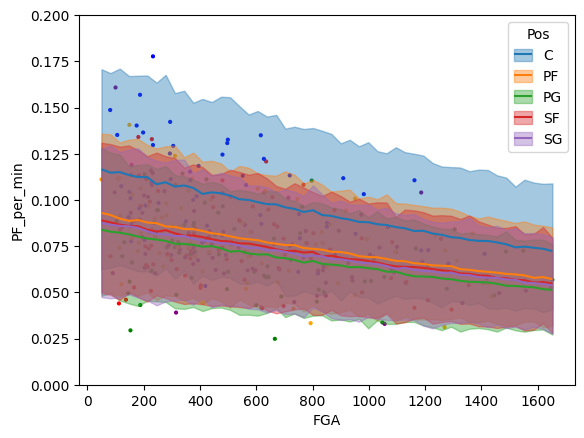

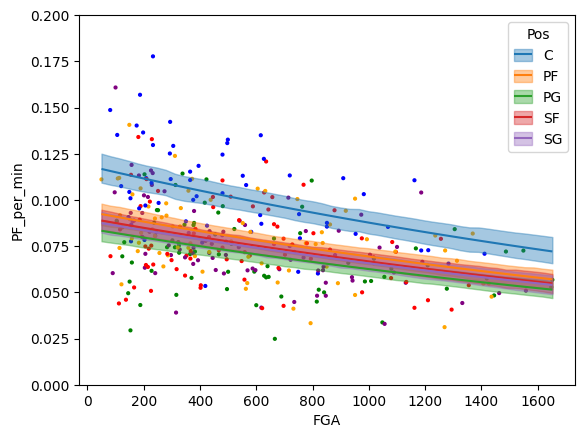

In [26]:
fig, axx = plt.subplots() # creates a graph

axx.scatter(x=basketball.FGA,y=basketball.PF_per_min, c=basketball.BB_color, s=4) # adds players onto the graph
axx.set_ylim(0,.2) # makes the y axis not crazy

bmb.interpret.plot_predictions(model_basketball, # plots the posterior
                               idata_basketball,
                               ["FGA", "Pos"],
                               ax=axx,
                               use_hdi=True,
                               pps=True)

# below code does the same thing but with average of posterior only

fig, axx = plt.subplots() # creates a graph

axx.scatter(x=basketball.FGA,y=basketball.PF_per_min, c=basketball.BB_color, s=4) # adds players onto the graph
axx.set_ylim(0,.2) # makes the y axis not crazy

bmb.interpret.plot_predictions(model_basketball, # plots the posterior
                               idata_basketball,
                               ["FGA", "Pos"],
                               ax=axx,
                               use_hdi=True,
                               pps=False)

<Axes: xlabel='PF_per_min'>

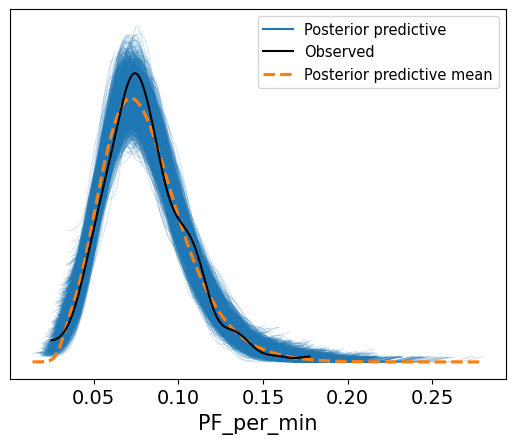

In [27]:
model_basketball.predict(idata_basketball, kind="response") # creates a posterior predictive
az.plot_ppc(idata_basketball) # plots ppc

These graphs are based on a model using FGAs. The x-axis is field goal attempts.

This looks pretty good to me. The ppc is perfect except for the peak, and the posterior seems to encapsulate the entirety of the data.

I'm now going to run a few advanced models to see if they are better. These models are the ones I think best align to reality, but they may not perform too well because while the variables all have an impact, the impact may be small and not noticeable.

None of these models will have interaction because I want to use a gamma likelihood.

In [28]:
possibleVarsNoInt = ['Pos + STL + BLK + TOV + TRB + FGA', 'Pos + STL + FGA + FT%', 'Pos + STL + MP + FT%'] # my complex models

In [29]:
for var in possibleVarsNoInt: # This is just a function to try every predictor variabe in a list. I'm only doing this so my code take up too many lines
  print(var)
  model_basketball = bmb.Model("PF_per_min ~ " + var, data=basketball, family='gamma', link='log')
  idata_basketball = model_basketball.fit(idata_kwargs={'log_likelihood': True})
  modelDict['Gamma-log: ' + var] = idata_basketball

Pos + STL + BLK + TOV + TRB + FGA


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 1499 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Pos + STL + FGA + FT%


Output()

Output()

ERROR:pymc.stats.convergence:There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Pos + STL + MP + FT%


Output()

Output()

ERROR:pymc.stats.convergence:There were 1000 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The classic duality of 0 divergences in one chain and 999 in the other. I blame bambi.

In [31]:
cmp_df = az.compare( modelDict )
cmp_df

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gamma-log: Pos + STL,0,8.941057e+02,7.023724e+00,0.000000e+00,1.000000e+00,1.382769e+01,0.000000e+00,False,log
Gamma-log: Pos + STL + BLK + TOV + TRB + FGA,1,-3.578832e+80,3.578832e+80,3.578832e+80,1.845692e-13,3.285262e+80,3.285262e+80,True,log
Gamma-log: Pos + STL + MP + FT%,2,-2.008768e+102,2.008768e+102,2.008768e+102,1.614673e-13,1.508195e+102,1.508195e+102,True,log
Gamma-log: Pos + STL + FGA + FT%,3,-8.206063e+110,8.206063e+110,8.206063e+110,0.000000e+00,8.194814e+110,8.194814e+110,True,log


So I don't think these models perform well. I'm guessing their failure has to do with bambi, but I'm not sure. I'm not going to use these because their elpd_loo sucks.

In the end, Pos + FGA worked the best out of the gamma models with Pos + MP getting second. It makes sense FGA worked well because it combines MP and Physicality, both of which affect PFs. Since the posterior of Pos + FGA looked good, I'm going to choose it as my final model.

## Conclusion

The most significant part of modelling PFs per minute seems to be position. There is little improvements to a model with Pos, and it seems FGA has the best improvement. FGA combines MP and Physicality, both of which I assumed affect PFs, so it makes sense it does well.